In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np


from mid_simulations.simulation_funcs import (
    get_events_df_for_subject,
)

In [2]:
figure_output_path = (
    '/Users/jeanettemumford/Dropbox/Research/Projects/russ/MID_paper_figures'
)

## How do stimulus duration differences vary across cue types and hit/miss?

In [3]:
def get_all_durations(sub):
    events = get_events_df_for_subject(sub, dataset='ABCD')
    events['TD1_ONSET'] = events['PROBE_ONSET'] + events['PROBE_DURATION']
    events['TD1_DURATION'] = events['FEEDBACK_ONSET'] - events['TD1_ONSET']
    events = events.rename(
        columns={
            'FIXATION_DURATION': 'Fixation_DURATION',
            'PROBE_DURATION': 'Probe_DURATION',
            'CUE_DURATION': 'Cue_DURATION',
            'FEEDBACK_DURATION': 'Feedback_DURATION',
        }
    )
    average_dur = events.groupby(['TRIAL_TYPE', 'PROBE_HIT'])[
        [
            'Cue_DURATION',
            'Fixation_DURATION',
            'Probe_DURATION',
            'TD1_DURATION',
            'Feedback_DURATION',
        ]
    ].mean()
    average_dur = average_dur.reset_index()
    return average_dur

In [4]:
all_dfs_duration = []
for sub in range(1, 501):
    df = get_all_durations(sub)
    all_dfs_duration.append(df)
concatenated_df_duration = pd.concat(all_dfs_duration, ignore_index=True)

In [5]:
concatenated_df_duration_long = pd.melt(
    concatenated_df_duration,
    id_vars=['TRIAL_TYPE', 'PROBE_HIT'],
    value_vars=[col for col in concatenated_df_duration.columns if 'DURATION' in col],
    var_name='Stimulus',
    value_name='DURATION',
)
concatenated_df_duration_long['Stimulus'] = concatenated_df_duration_long[
    'Stimulus'
].str.replace('_DURATION', '')
concatenated_df_duration_long['stimulus_outcome'] = concatenated_df_duration_long.apply(
    lambda row: f"{row['Stimulus']}/Hit"
    if row['PROBE_HIT'] == 1
    else f"{row['Stimulus']}/Miss",
    axis=1,
)


In [6]:
mean_duration_per_outcome = (
    concatenated_df_duration_long.groupby('Stimulus')['DURATION'].mean().reset_index()
)

min_duration_per_outcome = (
    concatenated_df_duration_long.groupby('Stimulus')['DURATION'].min().reset_index()
)
max_duration_per_outcome = (
    concatenated_df_duration_long.groupby('Stimulus')['DURATION'].max().reset_index()
)
print('minimums')
print(min_duration_per_outcome * 1000)
print('\n maximums')

print(max_duration_per_outcome * 1000)


minimums
                                            Stimulus     DURATION
0  CueCueCueCueCueCueCueCueCueCueCueCueCueCueCueC...  1781.222222
1  FeedbackFeedbackFeedbackFeedbackFeedbackFeedba...  1473.714286
2  FixationFixationFixationFixationFixationFixati...  1500.000000
3  ProbeProbeProbeProbeProbeProbeProbeProbeProbeP...   172.166667
4  TD1TD1TD1TD1TD1TD1TD1TD1TD1TD1TD1TD1TD1TD1TD1T...    53.666667

 maximums
                                            Stimulus     DURATION
0  CueCueCueCueCueCueCueCueCueCueCueCueCueCueCueC...  2039.666667
1  FeedbackFeedbackFeedbackFeedbackFeedbackFeedba...  1789.166667
2  FixationFixationFixationFixationFixationFixati...  3666.333333
3  ProbeProbeProbeProbeProbeProbeProbeProbeProbeP...   497.444444
4  TD1TD1TD1TD1TD1TD1TD1TD1TD1TD1TD1TD1TD1TD1TD1T...   109.000000


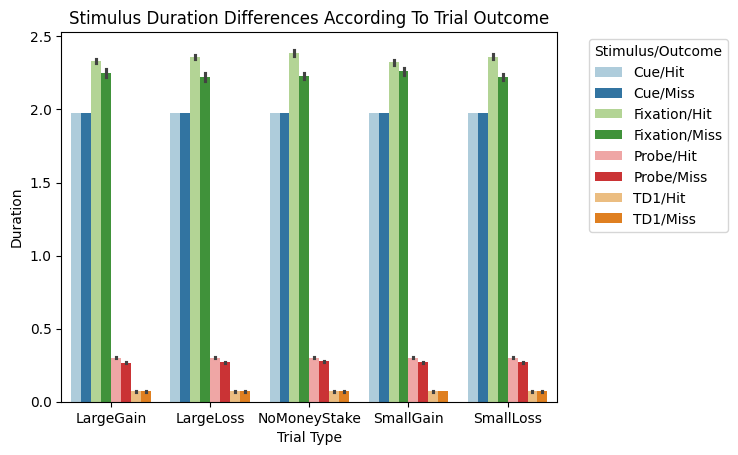

In [7]:
sns.barplot(
    x='TRIAL_TYPE',
    y='DURATION',
    hue='stimulus_outcome',
    data=concatenated_df_duration_long,
    palette='Paired',
    hue_order=[
        'Cue/Hit',
        'Cue/Miss',
        'Fixation/Hit',
        'Fixation/Miss',
        'Probe/Hit',
        'Probe/Miss',
        'TD1/Hit',
        'TD1/Miss',
    ],
)
plt.legend(title='Stimulus/Outcome', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel('Duration')
plt.xlabel('Trial Type')
plt.title('Stimulus Duration Differences According To Trial Outcome')
plt.show()

In [8]:
concatenated_df_duration_long
duration_long_no_td1 = concatenated_df_duration_long[
    concatenated_df_duration_long['Stimulus'] != 'TD1'
]

#### Calculate average difference in fixations between Hits and Miss

In [9]:
mean_duration_per_trial_type = (
    duration_long_no_td1.groupby(['TRIAL_TYPE', 'stimulus_outcome'])['DURATION']
    .mean()
    .reset_index()
)

mean_duration_per_trial_type['Stimulus'] = (
    mean_duration_per_trial_type['stimulus_outcome'].str.split('/').str[0]
)


# Subtract odd rows from even rows
diffs = mean_duration_per_trial_type.iloc[::2].reset_index(drop=True)
diffs['DURATION_DIFF'] = (
    diffs['DURATION'].values
    - mean_duration_per_trial_type.iloc[1::2]['DURATION'].values
)

print(diffs[~diffs['Stimulus'].str.contains('Cue|Feedback|Probe')])
print('')
print(diffs[~diffs['Stimulus'].str.contains('Cue|Feedback|Fixation')])


      TRIAL_TYPE stimulus_outcome  DURATION  Stimulus  DURATION_DIFF
2      LargeGain     Fixation/Hit  2.330631  Fixation       0.079832
6      LargeLoss     Fixation/Hit  2.359066  Fixation       0.135438
10  NoMoneyStake     Fixation/Hit  2.386313  Fixation       0.157921
14     SmallGain     Fixation/Hit  2.323420  Fixation       0.062957
18     SmallLoss     Fixation/Hit  2.361166  Fixation       0.141807

      TRIAL_TYPE stimulus_outcome  DURATION Stimulus  DURATION_DIFF
3      LargeGain        Probe/Hit  0.300891    Probe       0.033828
7      LargeLoss        Probe/Hit  0.300463    Probe       0.031370
11  NoMoneyStake        Probe/Hit  0.301804    Probe       0.026277
15     SmallGain        Probe/Hit  0.301675    Probe       0.032627
19     SmallLoss        Probe/Hit  0.301523    Probe       0.031042


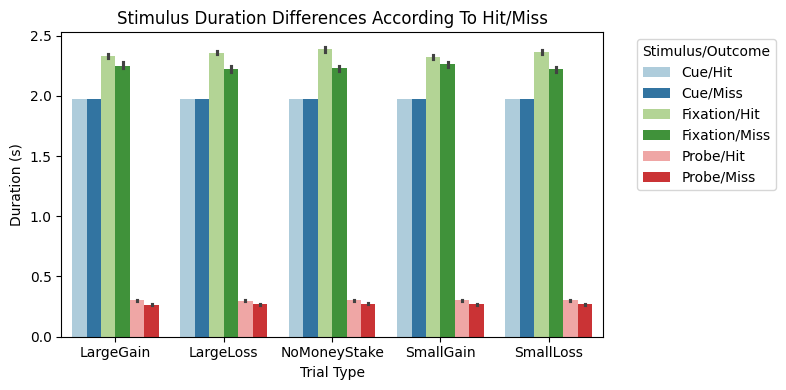

In [10]:
fig_path = f'{figure_output_path}/durations_hit_miss.pdf'

plt.figure(figsize=(8, 4))
sns.barplot(
    x='TRIAL_TYPE',
    y='DURATION',
    hue='stimulus_outcome',
    data=duration_long_no_td1,
    palette='Paired',
    hue_order=[
        'Cue/Hit',
        'Cue/Miss',
        'Fixation/Hit',
        'Fixation/Miss',
        'Probe/Hit',
        'Probe/Miss',
    ],
)
plt.legend(title='Stimulus/Outcome', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel('Duration (s)')
plt.xlabel('Trial Type')
plt.title('Stimulus Duration Differences According To Hit/Miss')
plt.tight_layout()
plt.savefig(fig_path)
plt.show()

## How do RTs vary across cue types and hit/miss?

In [11]:
def get_all_rts(sub):
    events = get_events_df_for_subject(sub, dataset='ABCD')
    events = events.rename(columns={'RT_corrected': 'Response Time'})
    average_rt = events.groupby(['TRIAL_TYPE', 'PROBE_HIT'])[['Response Time']].mean()
    average_rt = average_rt.reset_index()
    return average_rt

In [12]:
all_dfs_rts = []
for sub in range(1, 501):
    df = get_all_rts(sub)
    all_dfs_rts.append(df)
concatenated_df_rts = pd.concat(all_dfs_rts, ignore_index=True)

In [13]:
concatenated_df_rts['stimulus_outcome'] = concatenated_df_duration_long.apply(
    lambda row: f'Hit' if row['PROBE_HIT'] == 1 else f'Miss', axis=1
)


In [14]:
concatenated_df_rts['Response Time'].min(), concatenated_df_rts['Response Time'].max()

(np.float64(105.5), np.float64(1581.0))

In [15]:
mean_rt_per_trial_type = (
    concatenated_df_rts.groupby(['TRIAL_TYPE', 'stimulus_outcome'])['Response Time']
    .mean()
    .reset_index()
)

# Subtract odd rows from even rows
diffs = mean_rt_per_trial_type.iloc[::2].reset_index(drop=True)
diffs['RT_DIFF (hit-miss)'] = (
    diffs['Response Time'].values
    - mean_rt_per_trial_type.iloc[1::2]['Response Time'].values
)
print(diffs)

     TRIAL_TYPE stimulus_outcome  Response Time  RT_DIFF (hit-miss)
0     LargeGain              Hit     241.210454          -78.556657
1     LargeLoss              Hit     241.810548          -85.576991
2  NoMoneyStake              Hit     246.721201          -99.894827
3     SmallGain              Hit     244.046642          -83.518742
4     SmallLoss              Hit     243.312573          -95.835527


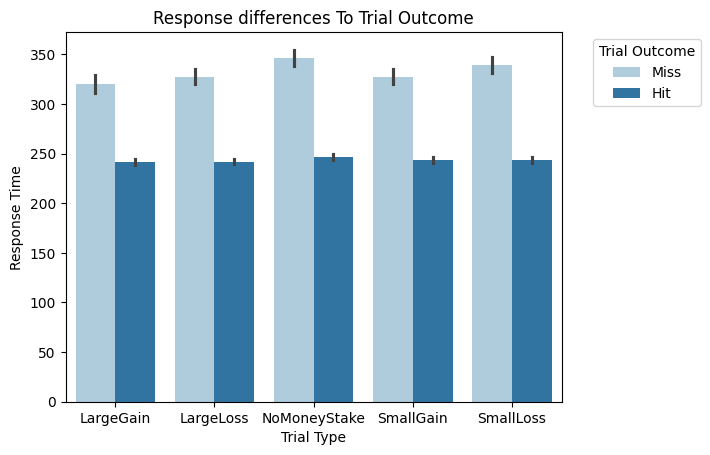

In [16]:
sns.barplot(
    x='TRIAL_TYPE',
    y='Response Time',
    hue='stimulus_outcome',
    data=concatenated_df_rts,
    palette='Paired',
)
plt.legend(title='Trial Outcome', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel('Response Time')
plt.xlabel('Trial Type')
plt.title('Response differences To Trial Outcome')
plt.show()

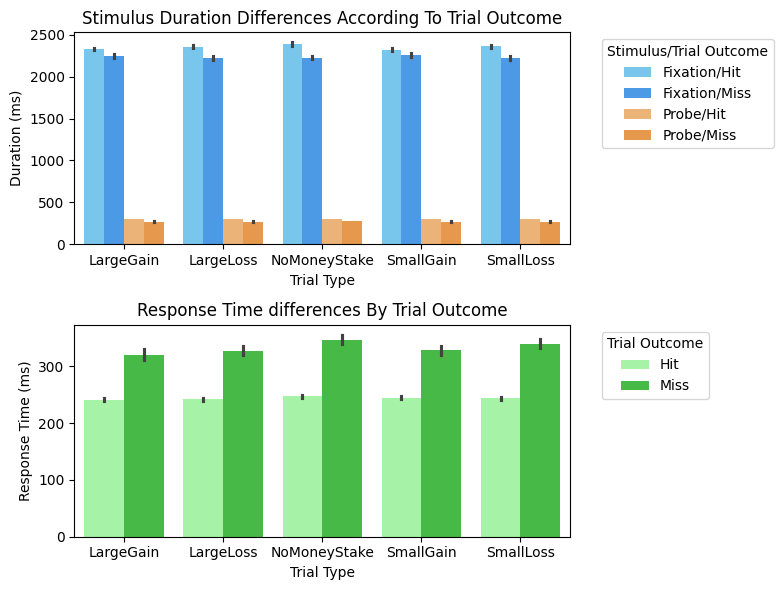

In [17]:
# Put the above two plots together
two_pairs = ['#66CCFF', '#3399FF', '#FFB366', '#FF9933']
one_pair = ['#99FF99', '#33CC33']


concatenated_df_duration_long_no_td1 = concatenated_df_duration_long.loc[
    concatenated_df_duration_long['Stimulus'] != 'TD1', :
].copy()
concatenated_df_duration_long_no_td1['duration_ms'] = (
    concatenated_df_duration_long_no_td1['DURATION'] * 1000
)

fig, axs = plt.subplots(2, 1, figsize=(8, 6))

sns.barplot(
    x='TRIAL_TYPE',
    y='duration_ms',
    hue='stimulus_outcome',
    data=concatenated_df_duration_long_no_td1,
    palette=two_pairs,
    hue_order=['Fixation/Hit', 'Fixation/Miss', 'Probe/Hit', 'Probe/Miss'],
    ax=axs[0],
)

axs[0].legend(
    title='Stimulus/Trial Outcome', bbox_to_anchor=(1.05, 1), loc='upper left'
)
axs[0].set_ylabel('Duration (ms)')
axs[0].set_xlabel('Trial Type')
axs[0].set_title('Stimulus Duration Differences According To Trial Outcome')

sns.barplot(
    x='TRIAL_TYPE',
    y='Response Time',
    hue='stimulus_outcome',
    data=concatenated_df_rts,
    palette=one_pair,
    ax=axs[1],
    hue_order=['Hit', 'Miss'],
)
axs[1].legend(title='Trial Outcome', bbox_to_anchor=(1.05, 1), loc='upper left')
axs[1].set_ylabel('Response Time (ms)')
axs[1].set_xlabel('Trial Type')
axs[1].set_title('Response Time differences By Trial Outcome')
plt.tight_layout()
plt.savefig(f'{figure_output_path}/durations_rts_by_hit_miss.pdf')

plt.show()

In [18]:
concatenated_df_duration_long_no_td1
concatenated_df_duration_long_no_td1[['Stimulus_new', 'Outcome']] = (
    concatenated_df_duration_long_no_td1['stimulus_outcome'].str.split('/', expand=True)
)
concatenated_df_duration_long_no_td1

duration_data_fixation = concatenated_df_duration_long_no_td1[
    concatenated_df_duration_long_no_td1['Stimulus_new'] == 'Fixation'
]
duration_data_miss = duration_data_fixation[duration_data_fixation['Outcome'] == 'Miss']


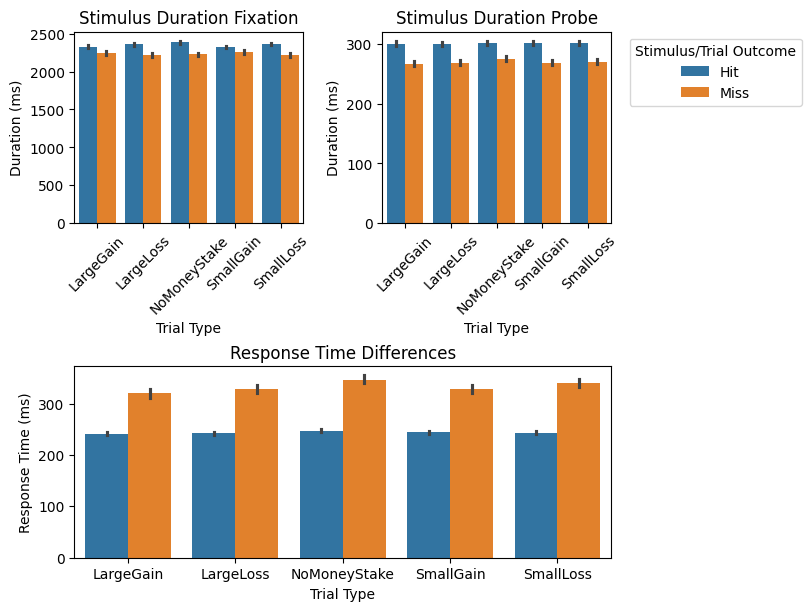

In [19]:
two_pairs = ['#66CCFF', '#3399FF', '#FFB366', '#FF9933']
one_pair = ['#99FF99', '#33CC33']
axs_label_fontsize = 10

concatenated_df_duration_long_no_td1 = concatenated_df_duration_long[
    concatenated_df_duration_long['Stimulus'] != 'TD1'
].copy()
concatenated_df_duration_long_no_td1['duration_ms'] = (
    concatenated_df_duration_long_no_td1['DURATION'] * 1000
)
concatenated_df_duration_long_no_td1[['Stimulus_new', 'Outcome']] = (
    concatenated_df_duration_long_no_td1['stimulus_outcome'].str.split('/', expand=True)
)

duration_data_fixation = concatenated_df_duration_long_no_td1[
    concatenated_df_duration_long_no_td1['Stimulus_new'] == 'Fixation'
]
duration_data_probe = concatenated_df_duration_long_no_td1[
    concatenated_df_duration_long_no_td1['Stimulus_new'] == 'Probe'
]

# fig, axs = plt.subplots(2, 1, figsize=(8,6))
fig = plt.figure(constrained_layout=True, figsize=(8, 6))
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

sns.barplot(
    x='TRIAL_TYPE',
    y='duration_ms',
    hue='Outcome',
    data=duration_data_fixation,
    hue_order=['Hit', 'Miss'],
    ax=ax1,
    legend=False,
)
ax1.set_ylabel('Duration (ms)', fontsize=axs_label_fontsize)
ax1.set_xlabel('Trial Type', fontsize=axs_label_fontsize)
ax1.set_title('Stimulus Duration Fixation')
ax1.tick_params(axis='x', labelsize=10, rotation=45)

sns.barplot(
    x='TRIAL_TYPE',
    y='duration_ms',
    hue='Outcome',
    data=duration_data_probe,
    hue_order=['Hit', 'Miss'],
    ax=ax2,
    legend=True,
)

ax2.set_ylabel('Duration (ms)', fontsize=axs_label_fontsize)
ax2.set_xlabel('Trial Type', fontsize=axs_label_fontsize)
ax2.set_title('Stimulus Duration Probe')
ax2.tick_params(axis='x', labelsize=10, rotation=45)
ax2.legend(title='Stimulus/Trial Outcome', bbox_to_anchor=(1.05, 1), loc='upper left')
sns.barplot(
    x='TRIAL_TYPE',
    y='Response Time',
    hue='stimulus_outcome',
    data=concatenated_df_rts,
    ax=ax3,
    hue_order=['Hit', 'Miss'],
    legend=False,
)

ax3.set_ylabel('Response Time (ms)', fontsize=axs_label_fontsize)
ax3.set_xlabel('Trial Type', fontsize=axs_label_fontsize)
ax3.set_title('Response Time Differences')
plt.savefig(f'{figure_output_path}/durations_rts_by_hit_miss_3panel_bar.pdf')

plt.show()

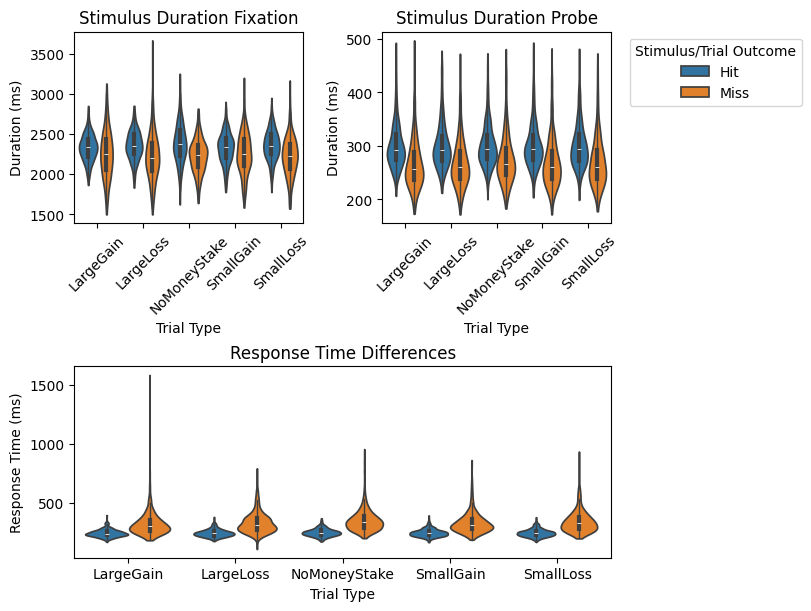

In [20]:
two_pairs = ['#66CCFF', '#3399FF', '#FFB366', '#FF9933']
one_pair = ['#99FF99', '#33CC33']
axs_label_fontsize = 10

concatenated_df_duration_long_no_td1 = concatenated_df_duration_long[
    concatenated_df_duration_long['Stimulus'] != 'TD1'
].copy()
concatenated_df_duration_long_no_td1['duration_ms'] = (
    concatenated_df_duration_long_no_td1['DURATION'] * 1000
)
concatenated_df_duration_long_no_td1[['Stimulus_new', 'Outcome']] = (
    concatenated_df_duration_long_no_td1['stimulus_outcome'].str.split('/', expand=True)
)

duration_data_fixation = concatenated_df_duration_long_no_td1[
    concatenated_df_duration_long_no_td1['Stimulus_new'] == 'Fixation'
]
duration_data_probe = concatenated_df_duration_long_no_td1[
    concatenated_df_duration_long_no_td1['Stimulus_new'] == 'Probe'
]

fig = plt.figure(constrained_layout=True, figsize=(8, 6))
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

sns.violinplot(
    x='TRIAL_TYPE',
    y='duration_ms',
    hue='Outcome',
    data=duration_data_fixation,
    hue_order=['Hit', 'Miss'],
    cut=0,
    inner_kws=dict(box_width=3),
    ax=ax1,
    legend=False,
)
ax1.set_ylabel('Duration (ms)', fontsize=axs_label_fontsize)
ax1.set_xlabel('Trial Type', fontsize=axs_label_fontsize)
ax1.set_title('Stimulus Duration Fixation')
ax1.tick_params(axis='x', labelsize=10, rotation=45)

sns.violinplot(
    x='TRIAL_TYPE',
    y='duration_ms',
    hue='Outcome',
    data=duration_data_probe,
    hue_order=['Hit', 'Miss'],
    cut=0,
    inner_kws=dict(box_width=3),
    ax=ax2,
    legend=True,
)

ax2.set_ylabel('Duration (ms)', fontsize=axs_label_fontsize)
ax2.set_xlabel('Trial Type', fontsize=axs_label_fontsize)
ax2.set_title('Stimulus Duration Probe')
ax2.tick_params(axis='x', labelsize=10, rotation=45)
ax2.legend(title='Stimulus/Trial Outcome', bbox_to_anchor=(1.05, 1), loc='upper left')
sns.violinplot(
    x='TRIAL_TYPE',
    y='Response Time',
    hue='stimulus_outcome',
    data=concatenated_df_rts,
    ax=ax3,
    hue_order=['Hit', 'Miss'],
    cut=0,
    inner_kws=dict(box_width=3),
    legend=False,
)

ax3.set_ylabel('Response Time (ms)', fontsize=axs_label_fontsize)
ax3.set_xlabel('Trial Type', fontsize=axs_label_fontsize)
ax3.set_title('Response Time Differences')
plt.savefig(f'{figure_output_path}/durations_rts_by_hit_miss_violin.pdf')

plt.show()

# Look at stimulus durations and RTs by Correct/Too Slow/Too Soon

In [21]:
def get_response_proportions(sub):
    events = get_events_df_for_subject(sub, dataset='ABCD')
    response_counts = events['Response'].value_counts(normalize=True) * 100
    response_counts = response_counts.reset_index()
    response_dict = {
        row['Response']: [row['proportion']] for _, row in response_counts.iterrows()
    }
    return response_dict

In [22]:
for sub in range(1, 501):
    response_dict = get_response_proportions(sub)
    if sub == 1:
        all_sub_response_proportions = response_dict
    else:
        for key in response_dict:
            all_sub_response_proportions[key].extend(response_dict[key])


In [23]:
for key, val in all_sub_response_proportions.items():
    print(key)
    mean_val = np.mean(np.array(val))
    print(f'# of subjects = {len(val)}')
    print(f'Averaged proportion = {mean_val}\n')


Correct Response!
# of subjects = 500
Averaged proportion = 56.786

You pressed too slow!
# of subjects = 500
Averaged proportion = 36.236

You pressed too soon!
# of subjects = 495
Averaged proportion = 7.048484848484849



In [24]:
def get_all_durations_response_type(sub):
    events = get_events_df_for_subject(sub, dataset='ABCD')
    events['TD1_ONSET'] = events['PROBE_ONSET'] + events['PROBE_DURATION']
    events['TD1_DURATION'] = events['FEEDBACK_ONSET'] - events['TD1_ONSET']
    events = events.rename(
        columns={
            'FIXATION_DURATION': 'Fixation_DURATION',
            'PROBE_DURATION': 'Probe_DURATION',
        }
    )
    average_dur = events.groupby(['TRIAL_TYPE', 'Response'])[
        ['Fixation_DURATION', 'Probe_DURATION', 'TD1_DURATION']
    ].mean()
    average_dur = average_dur.reset_index()
    return average_dur


all_dfs_duration_response_type = []
for sub in range(1, 501):
    df = get_all_durations_response_type(sub)
    all_dfs_duration_response_type.append(df)
concatenated_df_duration_response_type = pd.concat(
    all_dfs_duration_response_type, ignore_index=True
)

In [25]:
concatenated_df_duration_response_type_long = pd.melt(
    concatenated_df_duration_response_type,
    id_vars=['TRIAL_TYPE', 'Response'],
    value_vars=[
        col
        for col in concatenated_df_duration_response_type.columns
        if 'DURATION' in col
    ],
    var_name='Stimulus',
    value_name='DURATION',
)
concatenated_df_duration_response_type_long['Stimulus'] = (
    concatenated_df_duration_response_type_long['Stimulus'].str.replace('_DURATION', '')
)
concatenated_df_duration_response_type_long['stimulus_outcome'] = (
    concatenated_df_duration_response_type_long.apply(
        lambda row: f"{row['Stimulus']}/{row['Response']}", axis=1
    )
)


In [26]:
def get_all_rts_response_type(sub):
    events = get_events_df_for_subject(sub, dataset='ABCD')
    events = events.rename(columns={'RT_corrected': 'Response Time'})
    average_rt = events.groupby(['TRIAL_TYPE', 'Response'])[['Response Time']].mean()
    average_rt = average_rt.reset_index()
    return average_rt


all_dfs_rts_response_type = []
for sub in range(1, 501):
    df = get_all_rts_response_type(sub)
    all_dfs_rts_response_type.append(df)
concatenated_df_rts_response_type = pd.concat(
    all_dfs_rts_response_type, ignore_index=True
)

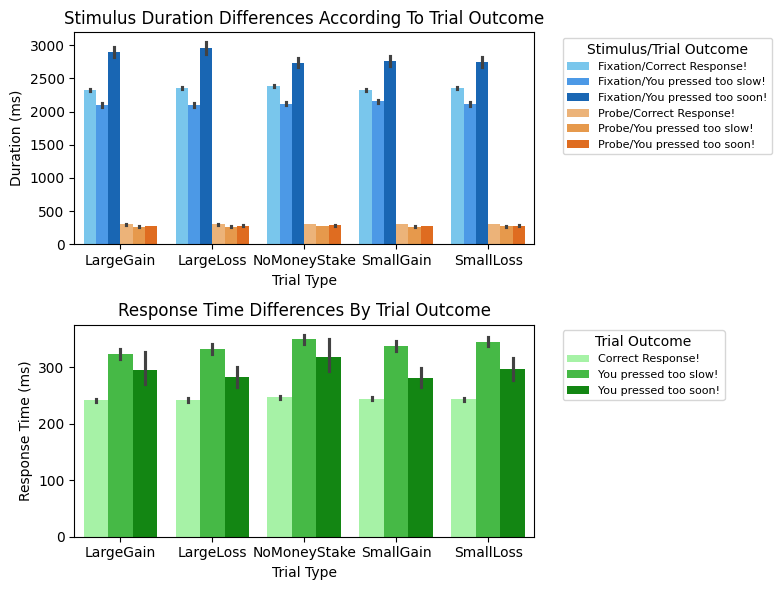

In [27]:
concatenated_df_duration_response_type_long_no_td1 = (
    concatenated_df_duration_response_type_long[
        concatenated_df_duration_response_type_long['Stimulus'] != 'TD1'
    ].copy()
)

concatenated_df_duration_response_type_long_no_td1['duration_ms'] = (
    concatenated_df_duration_response_type_long_no_td1['DURATION'].values * 1000
)


# colors
two_triples = ['#66CCFF', '#3399FF', '#0066CC', '#FFB366', '#FF9933', '#FF6600']
one_triple = ['#99FF99', '#33CC33', '#009900']


fig_path = f'{figure_output_path}/durations_rts_by_trial_type.pdf'
fig, axs = plt.subplots(2, 1, figsize=(8, 6))

bar_palette = sns.color_palette('Paired')

sns.barplot(
    x='TRIAL_TYPE',
    y='duration_ms',
    hue='stimulus_outcome',
    data=concatenated_df_duration_response_type_long_no_td1,
    palette=two_triples,
    hue_order=[
        'Fixation/Correct Response!',
        'Fixation/You pressed too slow!',
        'Fixation/You pressed too soon!',
        'Probe/Correct Response!',
        'Probe/You pressed too slow!',
        'Probe/You pressed too soon!',
    ],
    ax=axs[0],
)

axs[0].legend(
    title='Stimulus/Trial Outcome',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    fontsize=8,
)
axs[0].set_ylabel('Duration (ms)')
axs[0].set_xlabel('Trial Type')
axs[0].set_title('Stimulus Duration Differences According To Trial Outcome')

sns.barplot(
    x='TRIAL_TYPE',
    y='Response Time',
    hue='Response',
    data=concatenated_df_rts_response_type,
    palette=one_triple,
    ax=axs[1],
    hue_order=['Correct Response!', 'You pressed too slow!', 'You pressed too soon!'],
)
axs[1].legend(
    title='Trial Outcome', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8
)
axs[1].set_ylabel('Response Time (ms)')
axs[1].set_xlabel('Trial Type')
axs[1].set_title('Response Time Differences By Trial Outcome')

plt.tight_layout()
plt.savefig(fig_path, bbox_inches='tight')
plt.show()


/var/folders/y4/qn1yzt191kb4h4vwfbmgvt340000gn/T/ipykernel_6501/530350615.py:58: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


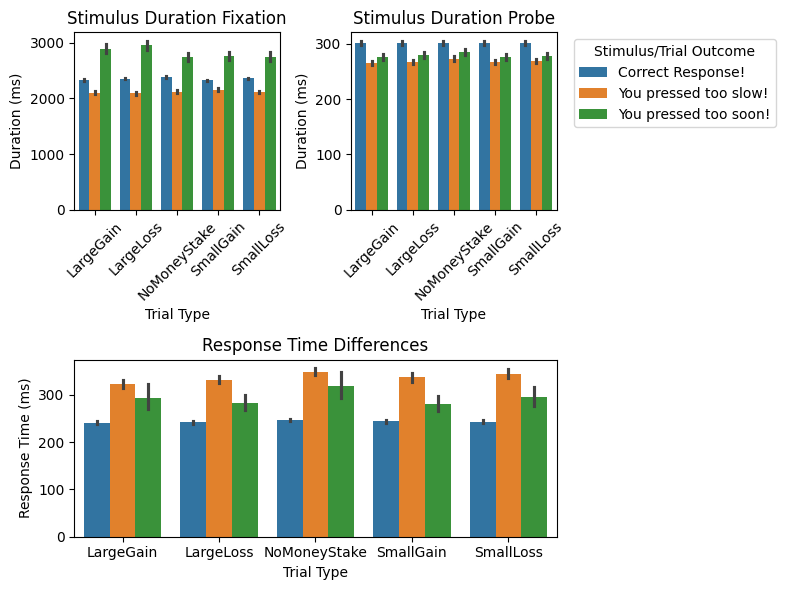

In [28]:
duration_data_fixation = concatenated_df_duration_response_type_long_no_td1[
    concatenated_df_duration_response_type_long_no_td1['Stimulus'] == 'Fixation'
]
duration_data_probe = concatenated_df_duration_response_type_long_no_td1[
    concatenated_df_duration_response_type_long_no_td1['Stimulus'] == 'Probe'
]

fig = plt.figure(constrained_layout=True, figsize=(8, 6))
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

sns.barplot(
    x='TRIAL_TYPE',
    y='duration_ms',
    hue='Response',
    data=duration_data_fixation,
    hue_order=['Correct Response!', 'You pressed too slow!', 'You pressed too soon!'],
    ax=ax1,
    legend=False,
)
ax1.set_ylabel('Duration (ms)', fontsize=axs_label_fontsize)
ax1.set_xlabel('Trial Type', fontsize=axs_label_fontsize)
ax1.set_title('Stimulus Duration Fixation')
ax1.tick_params(axis='x', labelsize=10, rotation=45)
# ax1.legend(
#     title='Stimulus/Trial Outcome',  loc='upper left'
# )
sns.barplot(
    x='TRIAL_TYPE',
    y='duration_ms',
    hue='Response',
    data=duration_data_probe,
    hue_order=['Correct Response!', 'You pressed too slow!', 'You pressed too soon!'],
    ax=ax2,
    legend=True,
)

ax2.set_ylabel('Duration (ms)', fontsize=axs_label_fontsize)
ax2.set_xlabel('Trial Type', fontsize=axs_label_fontsize)
ax2.set_title('Stimulus Duration Probe')
ax2.tick_params(axis='x', labelsize=10, rotation=45)
ax2.legend(title='Stimulus/Trial Outcome', bbox_to_anchor=(1.05, 1), loc='upper left')
sns.barplot(
    x='TRIAL_TYPE',
    y='Response Time',
    hue='Response',
    data=concatenated_df_rts_response_type,
    ax=ax3,
    hue_order=['Correct Response!', 'You pressed too slow!', 'You pressed too soon!'],
    legend=False,
)

ax3.set_ylabel('Response Time (ms)', fontsize=axs_label_fontsize)
ax3.set_xlabel('Trial Type', fontsize=axs_label_fontsize)
ax3.set_title('Response Time Differences')
plt.tight_layout()
plt.savefig(f'{figure_output_path}/durations_rts_by_trial_outcome_3_panel_barplot.pdf')

plt.show()

/var/folders/y4/qn1yzt191kb4h4vwfbmgvt340000gn/T/ipykernel_6501/1565734530.py:62: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


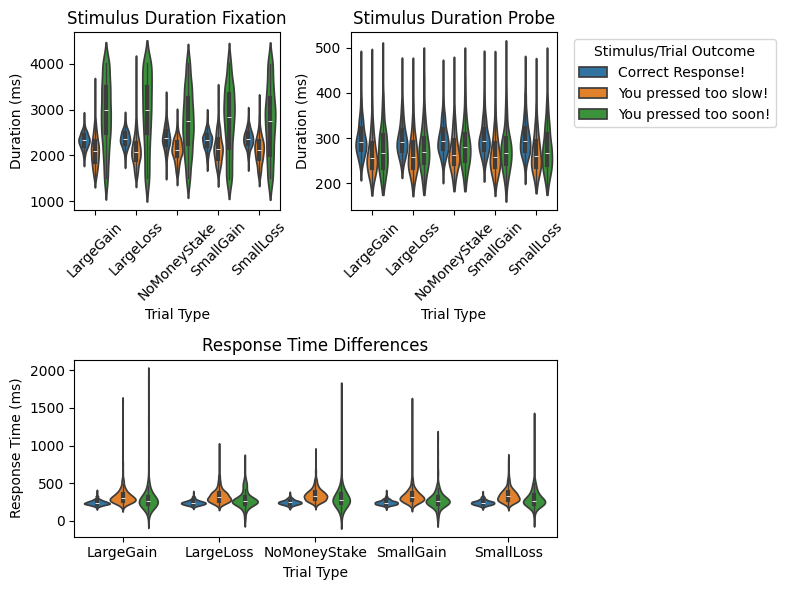

In [29]:
# violin plots

duration_data_fixation = concatenated_df_duration_response_type_long_no_td1[
    concatenated_df_duration_response_type_long_no_td1['Stimulus'] == 'Fixation'
]
duration_data_probe = concatenated_df_duration_response_type_long_no_td1[
    concatenated_df_duration_response_type_long_no_td1['Stimulus'] == 'Probe'
]

fig = plt.figure(constrained_layout=True, figsize=(8, 6))
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

sns.violinplot(
    x='TRIAL_TYPE',
    y='duration_ms',
    hue='Response',
    data=duration_data_fixation,
    hue_order=['Correct Response!', 'You pressed too slow!', 'You pressed too soon!'],
    inner_kws=dict(box_width=3),
    ax=ax1,
    legend=False,
)
ax1.set_ylabel('Duration (ms)', fontsize=axs_label_fontsize)
ax1.set_xlabel('Trial Type', fontsize=axs_label_fontsize)
ax1.set_title('Stimulus Duration Fixation')
ax1.tick_params(axis='x', labelsize=10, rotation=45)

sns.violinplot(
    x='TRIAL_TYPE',
    y='duration_ms',
    hue='Response',
    data=duration_data_probe,
    hue_order=['Correct Response!', 'You pressed too slow!', 'You pressed too soon!'],
    cut=0,
    inner_kws=dict(box_width=3),
    ax=ax2,
    legend=True,
)

ax2.set_ylabel('Duration (ms)', fontsize=axs_label_fontsize)
ax2.set_xlabel('Trial Type', fontsize=axs_label_fontsize)
ax2.set_title('Stimulus Duration Probe')
ax2.tick_params(axis='x', labelsize=10, rotation=45)
ax2.legend(title='Stimulus/Trial Outcome', bbox_to_anchor=(1.05, 1), loc='upper left')
sns.violinplot(
    x='TRIAL_TYPE',
    y='Response Time',
    hue='Response',
    data=concatenated_df_rts_response_type,
    ax=ax3,
    hue_order=['Correct Response!', 'You pressed too slow!', 'You pressed too soon!'],
    inner_kws=dict(box_width=3),
    legend=False,
)

ax3.set_ylabel('Response Time (ms)', fontsize=axs_label_fontsize)
ax3.set_xlabel('Trial Type', fontsize=axs_label_fontsize)
ax3.set_title('Response Time Differences')
plt.tight_layout()
plt.savefig(f'{figure_output_path}/durations_rts_by_trial_outcome_violin.pdf')

plt.show()

In [30]:
average_duration_per_stimulus_outcome = (
    concatenated_df_duration_response_type_long_no_td1.groupby('stimulus_outcome')[
        'DURATION'
    ]
    .mean()
    .reset_index()
)
print(average_duration_per_stimulus_outcome)

                 stimulus_outcome  DURATION
0      Fixation/Correct Response!  2.352119
1  Fixation/You pressed too slow!  2.119275
2  Fixation/You pressed too soon!  2.816988
3         Probe/Correct Response!  0.301271
4     Probe/You pressed too slow!  0.268304
5     Probe/You pressed too soon!  0.278877


In [31]:
print('Fixation/You pressed too soon - Fixation/You pressed too slow')
print(
    average_duration_per_stimulus_outcome.loc[
        average_duration_per_stimulus_outcome['stimulus_outcome'].str.contains(
            'Fixation/You pressed too soon'
        ),
        'DURATION',
    ].values
    - average_duration_per_stimulus_outcome.loc[
        average_duration_per_stimulus_outcome['stimulus_outcome'].str.contains(
            'Fixation/You pressed too slow'
        ),
        'DURATION',
    ].values
)

print('Probe/You pressed too soon - Probe/You pressed too slow')
print(
    average_duration_per_stimulus_outcome.loc[
        average_duration_per_stimulus_outcome['stimulus_outcome'].str.contains(
            'Probe/You pressed too soon'
        ),
        'DURATION',
    ].values
    - average_duration_per_stimulus_outcome.loc[
        average_duration_per_stimulus_outcome['stimulus_outcome'].str.contains(
            'Probe/You pressed too slow'
        ),
        'DURATION',
    ].values
)

Fixation/You pressed too soon - Fixation/You pressed too slow
[0.69771288]
Probe/You pressed too soon - Probe/You pressed too slow
[0.01057288]


In [32]:
average_rt_per_stimulus_outcome = (
    concatenated_df_rts_response_type.groupby('Response')['Response Time']
    .mean()
    .reset_index()
)

print('Probe/You pressed too slow - Probe/You pressed too soon')
print(
    average_rt_per_stimulus_outcome.loc[
        average_rt_per_stimulus_outcome['Response'].str.contains(
            'You pressed too slow'
        ),
        'Response Time',
    ].values
    - average_rt_per_stimulus_outcome.loc[
        average_rt_per_stimulus_outcome['Response'].str.contains(
            'You pressed too soon'
        ),
        'Response Time',
    ].values
)

Probe/You pressed too slow - Probe/You pressed too soon
[42.81537482]
